In [1]:
# Create a new notebook in Google Colab
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Create a project folder
!mkdir -p /content/drive/MyDrive/crater_detection

# Install required packages
!pip install ultralytics
!pip install opencv-python-headless
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install kaggle

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitli

In [2]:
# Upload your kaggle.json API key
from google.colab import files
uploaded = files.upload()  # Upload your kaggle.json

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Search for planetary/crater datasets
!kaggle datasets list -s "mars crater"

# Download a specific dataset (replace with your chosen dataset)
!kaggle datasets download -d lincolnzh/martianlunar-crater-detection-dataset
!unzip martianlunar-crater-detection-dataset.zip -d /content/dataset

Saving kaggle.json to kaggle.json
ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
codebreaker619/mars-crater-study-dataset                        Mars Crater Study Dataset                             4068517  2021-01-11 06:25:49.220000            593         32  0.9411765        
lincolnzh/martianlunar-crater-detection-dataset                 Martian/Lunar Crater Detection Dataset               77604628  2022-02-15 00:18:51.217000           2478         29  0.9375           
docxian/mars-maps                                               Mars Maps                                             2616710  2021-01-11 19:43:34.940000             63  

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import glob

# Create YOLOv8 dataset structure
!mkdir -p /content/yolo_dataset/train/images
!mkdir -p /content/yolo_dataset/train/labels
!mkdir -p /content/yolo_dataset/val/images
!mkdir -p /content/yolo_dataset/val/labels

# Check dataset structure
!ls -la /content/dataset

# Find all image files
image_files = []
for ext in ['*.jpg', '*.png', '*.jpeg']:
    image_files.extend(glob.glob(f'/content/dataset/**/{ext}', recursive=True))

print(f"Found {len(image_files)} image files")

if len(image_files) == 0:
    print("No images found! Please check dataset structure.")
    # Display the dataset structure
    !find /content/dataset -type f | sort
else:
    # Split into train/val (80/20)
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

    print(f"Training images: {len(train_files)}")
    print(f"Validation images: {len(val_files)}")

    # Function to find label file for an image
    def find_label_file(img_path):
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        # Try common label locations
        possible_paths = [
            os.path.join(os.path.dirname(img_path).replace('images', 'labels'), f"{base_name}.txt"),
            os.path.join(os.path.dirname(os.path.dirname(img_path)), 'labels', f"{base_name}.txt"),
            os.path.join('/content/dataset/labels', f"{base_name}.txt")
        ]

        for path in possible_paths:
            if os.path.exists(path):
                return path
        return None

    # Copy files to YOLO structure
    for idx, img_path in enumerate(train_files):
        # Get filename
        filename = os.path.basename(img_path)

        # Copy image
        dest_path = f'/content/yolo_dataset/train/images/{filename}'
        shutil.copy(img_path, dest_path)

        # Find and copy label if exists
        label_path = find_label_file(img_path)
        if label_path:
            label_name = os.path.basename(label_path)
            shutil.copy(label_path, f'/content/yolo_dataset/train/labels/{label_name}')

        # Progress update
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(train_files)} training images")

    for idx, img_path in enumerate(val_files):
        # Get filename
        filename = os.path.basename(img_path)

        # Copy image
        dest_path = f'/content/yolo_dataset/val/images/{filename}'
        shutil.copy(img_path, dest_path)

        # Find and copy label if exists
        label_path = find_label_file(img_path)
        if label_path:
            label_name = os.path.basename(label_path)
            shutil.copy(label_path, f'/content/yolo_dataset/val/labels/{label_name}')

        # Progress update
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(val_files)} validation images")

    # Count files in each directory
    print("\nDataset Structure:")
    print(f"Train Images: {len(os.listdir('/content/yolo_dataset/train/images'))}")
    print(f"Train Labels: {len(os.listdir('/content/yolo_dataset/train/labels'))}")
    print(f"Val Images: {len(os.listdir('/content/yolo_dataset/val/images'))}")
    print(f"Val Labels: {len(os.listdir('/content/yolo_dataset/val/labels'))}")

total 69520
drwxr-xr-x 3 root root     4096 Apr 18 07:35 .
drwxr-xr-x 1 root root     4096 Apr 18 07:35 ..
-rw-r--r-- 1 root root 71169925 Feb 15  2022 best.pt
drwxr-xr-x 5 root root     4096 Apr 18 07:35 craters
Found 143 image files
Training images: 114
Validation images: 29
Processed 0/114 training images
Processed 100/114 training images
Processed 0/29 validation images

Dataset Structure:
Train Images: 114
Train Labels: 114
Val Images: 29
Val Labels: 29


In [4]:
# If your dataset doesn't have labels, create synthetic ones
# Only run this if labels are missing

def create_synthetic_labels():
    # Check if we have labels
    train_images = len(os.listdir('/content/yolo_dataset/train/images'))
    train_labels = len(os.listdir('/content/yolo_dataset/train/labels'))

    if train_labels < train_images * 0.5:  # If less than 50% of images have labels
        print("Creating synthetic labels for missing images...")

        # For training images
        for img_file in os.listdir('/content/yolo_dataset/train/images'):
            base_name = os.path.splitext(img_file)[0]
            label_file = f'/content/yolo_dataset/train/labels/{base_name}.txt'

            if not os.path.exists(label_file):
                # Create a simple label (center box covering 50% of image)
                with open(label_file, 'w') as f:
                    f.write("0 0.5 0.5 0.5 0.5")  # class_id x_center y_center width height

        # For validation images
        for img_file in os.listdir('/content/yolo_dataset/val/images'):
            base_name = os.path.splitext(img_file)[0]
            label_file = f'/content/yolo_dataset/val/labels/{base_name}.txt'

            if not os.path.exists(label_file):
                # Create a simple label (center box covering 50% of image)
                with open(label_file, 'w') as f:
                    f.write("0 0.5 0.5 0.5 0.5")  # class_id x_center y_center width height

        print("Synthetic labels created.")
        print(f"Train Labels: {len(os.listdir('/content/yolo_dataset/train/labels'))}")
        print(f"Val Labels: {len(os.listdir('/content/yolo_dataset/val/labels'))}")

# Call the function if needed
create_synthetic_labels()

In [5]:
# Create dataset.yaml for YOLOv8
with open('/content/dataset.yaml', 'w') as f:
    f.write("train: /content/yolo_dataset/train/images\n")
    f.write("val: /content/yolo_dataset/val/images\n")
    f.write("nc: 1\n")  # Number of classes (update if needed)
    f.write("names: ['crater']\n")  # Class names (update if needed)

# Verify the content
!cat /content/dataset.yaml

# Verify that images exist at the specified paths
!ls -la /content/yolo_dataset/train/images | head -5
!ls -la /content/yolo_dataset/val/images | head -5

train: /content/yolo_dataset/train/images
val: /content/yolo_dataset/val/images
nc: 1
names: ['crater']
total 9384
drwxr-xr-x 2 root root  12288 Apr 18 07:35 .
drwxr-xr-x 4 root root   4096 Apr 18 07:35 ..
-rw-r--r-- 1 root root  91828 Apr 18 07:35 010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg
-rw-r--r-- 1 root root  69008 Apr 18 07:35 011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg
total 2528
drwxr-xr-x 2 root root   4096 Apr 18 07:35 .
drwxr-xr-x 4 root root   4096 Apr 18 07:35 ..
-rw-r--r-- 1 root root  69273 Apr 18 07:35 013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.jpg
-rw-r--r-- 1 root root  76630 Apr 18 07:35 016_png.rf.1973f9540ae7f672257609a8e5721ab3.jpg


In [7]:
from ultralytics import YOLO

# Initialize a new YOLOv8 model (choose size based on your needs)
# 'n' = nano (smallest/fastest), 's' = small, 'm' = medium, 'l' = large, 'x' = xlarge (most accurate)
model = YOLO('yolov8n.pt')  # Start with pre-trained YOLOv8 nano model

# Verify YAML path exists
import os
yaml_path = '/content/dataset.yaml'
assert os.path.exists(yaml_path), f"YAML file not found at {yaml_path}"

# Train YOLOv8 on your dataset
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    patience=20,  # Early stopping patience
    batch=16,
    name='crater_model',
    save=True,  # Save checkpoint
    device=0  # GPU
)

# Plot training results
from ultralytics.utils.plotting import plot_results
plot_results(file='/content/runs/detect/crater_model')  # Plot results

# Export the model
model = YOLO('/content/runs/detect/crater_model/weights/best.pt')
model.export(format='onnx')  # Export to ONNX format for deployment

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=crater_model2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

train: Scanning /content/yolo_dataset/train/labels.cache... 114 images, 8 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 472.7±81.1 MB/s, size: 81.9 KB)


val: Scanning /content/yolo_dataset/val/labels.cache... 29 images, 3 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/crater_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/crater_model2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.48G      1.841      3.357        1.5         31        640: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         29        166     0.0102      0.536     0.0481      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.83G      1.619      2.924      1.348          2        640: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         29        166     0.0149      0.783      0.223      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.83G      1.699      1.951      1.315         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29        166     0.0155      0.813      0.115     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.83G      1.615      1.779      1.257         19        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29        166     0.0141      0.741     0.0989     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.83G      1.522      1.637      1.274         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         29        166     0.0139      0.729      0.111     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.83G        1.5      1.536      1.221         18        640: 100%|██████████| 8/8 [00:02<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29        166       0.52      0.117      0.174      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.83G      1.533      1.414      1.208         35        640: 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29        166      0.732      0.395      0.513      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.83G       1.51       1.53       1.24         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         29        166      0.355      0.283      0.255      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.83G       1.49      1.453      1.238         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29        166      0.261      0.412      0.235      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.83G      1.541      1.571       1.28         14        640: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29        166      0.324      0.434      0.256      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.83G      1.517       1.73      1.299          3        640: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         29        166      0.318      0.506      0.246      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.83G      1.411      1.388      1.187         34        640: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29        166      0.274      0.494      0.239      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.83G      1.473      1.371      1.207         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         29        166      0.481      0.434      0.429       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.83G      1.521      1.453      1.201         10        640: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         29        166      0.594      0.488      0.535      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.83G       1.54      1.353      1.233         27        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         29        166       0.63      0.518      0.563      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.83G      1.467      1.275      1.187         41        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         29        166      0.614      0.494      0.537      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.83G      1.467      1.277      1.226         14        640: 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         29        166      0.686      0.458       0.53      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.83G      1.409      1.316      1.259          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29        166       0.51      0.506      0.417      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.83G      1.476      1.306      1.224         37        640: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         29        166      0.602      0.578      0.567      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.83G      1.411      1.233      1.182         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         29        166      0.622      0.566        0.6      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.83G      1.455      1.307      1.224          4        640: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29        166      0.658      0.532      0.615      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.83G      1.425      1.248      1.213         17        640: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         29        166      0.566      0.572       0.59      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.83G      1.358      1.253      1.146         12        640: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         29        166      0.625      0.573      0.597      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.83G      1.408      1.214      1.181         15        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         29        166      0.601      0.571      0.618      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.83G      1.484      1.445      1.257          3        640: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         29        166      0.401      0.506       0.37      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.83G      1.385      1.155      1.152         26        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         29        166      0.467      0.596      0.495      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.83G      1.389      1.139      1.156         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         29        166      0.631      0.602      0.603      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.83G      1.469      1.255      1.202         12        640: 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         29        166      0.602      0.608      0.631      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.83G      1.369      1.122      1.162         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         29        166      0.594      0.602      0.591      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.83G      1.303      1.065      1.126         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         29        166      0.634      0.536      0.593      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.83G      1.422      1.456      1.215          2        640: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29        166      0.638      0.602      0.623      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.83G      1.447      1.479      1.258          2        640: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29        166      0.568      0.614      0.558      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.83G      1.362       1.12      1.183         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29        166       0.57      0.624      0.552      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.83G      1.317      1.104      1.124         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29        166      0.537      0.633      0.547      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.83G      1.314      1.067      1.118         30        640: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         29        166      0.591        0.6      0.567      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.83G      1.346      1.114      1.142         27        640: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         29        166      0.619      0.548      0.586      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.83G      1.394      1.255      1.193          5        640: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         29        166      0.617      0.645      0.662      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.83G      1.292      1.077      1.122         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         29        166      0.696      0.639      0.694      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.83G      1.351       1.07      1.184          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         29        166      0.663      0.615      0.654      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.83G      1.303      1.051      1.147         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         29        166      0.621      0.643      0.607      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.83G      1.212      1.026      1.115         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         29        166      0.622      0.654      0.655      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.83G      1.273      1.002      1.114         31        640: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         29        166      0.569      0.693      0.659       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.83G      1.239      1.004      1.114         10        640: 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         29        166      0.644      0.608      0.651      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.83G      1.303      1.001      1.138         13        640: 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29        166      0.559      0.669      0.587      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.83G      1.305      1.047      1.132         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         29        166      0.611       0.62      0.587      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.83G       1.25     0.9621      1.095         23        640: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         29        166      0.597      0.596      0.615      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.83G      1.252       1.15      1.163          6        640: 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29        166      0.601       0.62      0.655      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.83G      1.215     0.8952      1.095         10        640: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29        166      0.542      0.602      0.588      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.83G      1.247     0.9456      1.111         26        640: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         29        166      0.607      0.632      0.623      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.83G      1.314     0.9866      1.125         20        640: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         29        166      0.691       0.58      0.654      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.83G      1.227     0.9442      1.093         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         29        166       0.65       0.59      0.611      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.83G       1.35      1.066      1.134         11        640: 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         29        166      0.595      0.584      0.528      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.84G      1.237     0.9235      1.127         13        640: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         29        166      0.664      0.554      0.548      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.84G      1.153      0.892      1.077         16        640: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         29        166      0.654      0.572      0.594      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.84G      1.196     0.8957      1.065         52        640: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29        166      0.675       0.59      0.616       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.84G       1.23     0.8703       1.07         38        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         29        166       0.69      0.614      0.638      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.84G       1.22     0.9216      1.077         15        640: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         29        166      0.727      0.614      0.676      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.84G      1.208     0.8876      1.105         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         29        166      0.722      0.614      0.682      0.379
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 38, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



58 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/crater_model2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/crater_model2/weights/best.pt, 6.2MB

Validating runs/detect/crater_model2/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


                   all         29        166      0.694      0.639      0.694      0.427
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/crater_model2


AssertionError: No results.csv files found in /content/runs/detect, nothing to plot.

In [8]:
# Correct the path for plotting results
from ultralytics.utils.plotting import plot_results
import glob

# Find the results.csv file
results_files = glob.glob('/content/runs/detect/crater_model/*.csv')
print(f"Found results files: {results_files}")

if results_files:
    # Use the first results file found
    plot_results(file=results_files[0])
else:
    print("No results.csv files found, skipping plotting")

Found results files: ['/content/runs/detect/crater_model/results.csv']


In [9]:
# Load the best model
from ultralytics import YOLO
model = YOLO('/content/runs/detect/crater_model/weights/best.pt')

# Export to ONNX format
model.export(format='onnx')
print("Model exported to ONNX format")

# You can also export to other formats if needed
# model.export(format='torchscript')  # TorchScript
# model.export(format='openvino')     # OpenVINO

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/crater_model/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 309.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 310.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 218.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 270.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 249.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun com

In [10]:
# Force TensorFlow to use CPU for this particular task
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU for TensorFlow

import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2  # Lighter model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import pickle

# Create directories for validation dataset
!mkdir -p /content/validation_data/planetary
!mkdir -p /content/validation_data/non_planetary

# Copy some crater images to use as planetary examples
import glob
planetary_images = glob.glob("/content/yolo_dataset/train/images/*")[:30]
for i, img_path in enumerate(planetary_images):
    shutil.copy(img_path, f'/content/validation_data/planetary/planet_{i}.jpg')

print("Please upload some non-planetary images (buildings, people, etc.):")
from google.colab import files
uploaded = files.upload()  # Upload non-planetary images
for filename in uploaded.keys():
    shutil.copy(filename, f'/content/validation_data/non_planetary/{filename}')

# Use a lighter model and ensure it runs on CPU
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    try:
        # Error handling for image loading
        try:
            img = image.load_img(img_path, target_size=(224, 224))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Use with statement to ensure proper cleanup
        with tf.device('/cpu:0'):
            features = base_model.predict(x, verbose=0)

        return features.flatten()
    except Exception as e:
        print(f"Feature extraction error for {img_path}: {e}")
        return None

# Extract features from all images with error handling
features = []
labels = []

# Planetary images (positive)
for img_file in os.listdir('/content/validation_data/planetary'):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join('/content/validation_data/planetary', img_file)
        feat = extract_features(img_path)
        if feat is not None:
            features.append(feat)
            labels.append(1)  # 1 for planetary

# Non-planetary images (negative)
for img_file in os.listdir('/content/validation_data/non_planetary'):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join('/content/validation_data/non_planetary', img_file)
        feat = extract_features(img_path)
        if feat is not None:
            features.append(feat)
            labels.append(0)  # 0 for non-planetary

# Only proceed if we have sufficient data
if len(features) > 5:  # At least a few examples of each class
    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Split into train/test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    # Evaluate
    from sklearn.metrics import classification_report, accuracy_score
    y_pred = classifier.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

    # Save the classifier
    with open('/content/planetary_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f)
else:
    print("Not enough valid images found for classifier training.")

    # Create a simple fallback classifier that always predicts "planetary"
    class FallbackClassifier:
        def predict(self, X):
            return np.ones(len(X))

        def predict_proba(self, X):
            probs = np.zeros((len(X), 2))
            probs[:, 1] = 1.0  # Always predict class 1 (planetary)
            return probs

    classifier = FallbackClassifier()
    with open('/content/planetary_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f)
    print("Created fallback classifier that always predicts 'planetary'")

Please upload some non-planetary images (buildings, people, etc.):


Saving I am sharing 'Scan 07 Dec 24 22·40·03' with you.jpg to I am sharing 'Scan 07 Dec 24 22·40·03' with you.jpg
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Feature extraction error for /content/validation_data/planetary/planet_21.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_23.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_15.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_8.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_17.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_9.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_0.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_27.jpg: name 'tf' is not defined
Feature 

In [11]:
def is_planetary_surface(image_path, classifier, feature_extractor=extract_features):
    """Check if an image is a planetary surface"""
    # Handle array input (from video frames)
    if isinstance(image_path, np.ndarray):
        # Save temporarily and process
        temp_path = '/content/temp_image.jpg'
        cv2.imwrite(temp_path, image_path)
        image_path = temp_path

    features = feature_extractor(image_path)
    prediction = classifier.predict_proba([features])[0]
    return prediction[1] > 0.5  # Threshold can be adjusted

def process_image(image_path, yolo_model, surface_classifier):
    """Process a single image with validation"""
    # Handle array input
    if isinstance(image_path, np.ndarray):
        # Save temporarily and process
        temp_path = '/content/temp_image.jpg'
        cv2.imwrite(temp_path, image_path)
        image_path = temp_path

    # Check if the image is a planetary surface
    if not is_planetary_surface(image_path, surface_classifier):
        print("WARNING: Image doesn't appear to be a planetary surface!")

        # Load image for visualization
        img = cv2.imread(image_path)
        # Add warning text
        cv2.putText(img, "WARNING: Not a planetary surface", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        return img, "Not a planetary surface"

    # Process with YOLOv8
    results = yolo_model.predict(image_path)
    return results[0].plot(), "Success"

def process_video(video_path, yolo_model, surface_classifier, output_path='output_video.mp4'):
    """Process a video with validation on key frames"""
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Process frames
    frame_count = 0
    is_valid = True
    check_interval = 30  # Check every 30 frames

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Check if frame is a planetary surface (every N frames)
        if frame_count % check_interval == 0:
            # Save frame temporarily
            temp_frame_path = '/content/temp_frame.jpg'
            cv2.imwrite(temp_frame_path, frame)

            # Check if it's a planetary surface
            is_valid = is_planetary_surface(temp_frame_path, surface_classifier)

        # Add warning if not a planetary surface
        if not is_valid:
            cv2.putText(frame, "WARNING: Not a planetary surface", (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Process with YOLOv8
        results = yolo_model(frame)
        annotated_frame = results[0].plot()

        # Write frame
        out.write(annotated_frame)
        frame_count += 1

        # Print progress
        if frame_count % 100 == 0:
            print(f"Processed {frame_count}/{total_frames} frames")

    # Release resources
    cap.release()
    out.release()
    return output_path

In [16]:
# Load your trained YOLOv8 model
yolo_model = YOLO('/content/runs/detect/crater_model/weights/best.pt')

# Load the planetary surface classifier
with open('/content/planetary_classifier.pkl', 'rb') as f:
    surface_classifier = pickle.load(f)

# Test on a planetary image
print("Upload a planetary surface image to test:")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
result_img, status = process_image(test_image_path, yolo_model, surface_classifier)

# Display the result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(status)
plt.show()

# Test on a non-planetary image
print("Upload a non-planetary image to test:")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
result_img, status = process_image(test_image_path, yolo_model, surface_classifier)

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(status)
plt.show()

Upload a planetary surface image to test:


IndexError: list index out of range

In [13]:
# Create directory in Google Drive if it doesn't exist
!mkdir -p /content/drive/MyDrive/crater_detection

# Save models to Google Drive
!cp /content/runs/detect/crater_model/weights/best.pt /content/drive/MyDrive/crater_detection/
!cp /content/runs/detect/crater_model/weights/best.onnx /content/drive/MyDrive/crater_detection/
!cp /content/planetary_classifier.pkl /content/drive/MyDrive/crater_detection/

# Download models locally
files.download('/content/runs/detect/crater_model/weights/best.pt')
files.download('/content/runs/detect/crater_model/weights/best.onnx')
files.download('/content/planetary_classifier.pkl')

print("Models saved successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models saved successfully!


In [14]:
# Upload a video file to test (if available)
print("Upload a video file to test (optional):")
try:
    uploaded = files.upload()
    if uploaded:
        video_path = list(uploaded.keys())[0]
        output_video = process_video(video_path, yolo_model, surface_classifier)
        print(f"Processed video saved to: {output_video}")
        files.download(output_video)
except:
    print("Video processing skipped")

Upload a video file to test (optional):


In [15]:
# prompt: how to know accuracy of the model

import matplotlib.pyplot as plt
import glob

# Find the results.csv file
results_files = glob.glob('/content/runs/detect/crater_model/*.csv')
print(f"Found results files: {results_files}")

if results_files:
    # Use the first results file found
    plot_results(file=results_files[0])
else:
    print("No results.csv files found, skipping plotting")


Found results files: ['/content/runs/detect/crater_model/results.csv']


Found results files: ['/content/runs/detect/crater_model/results.csv']


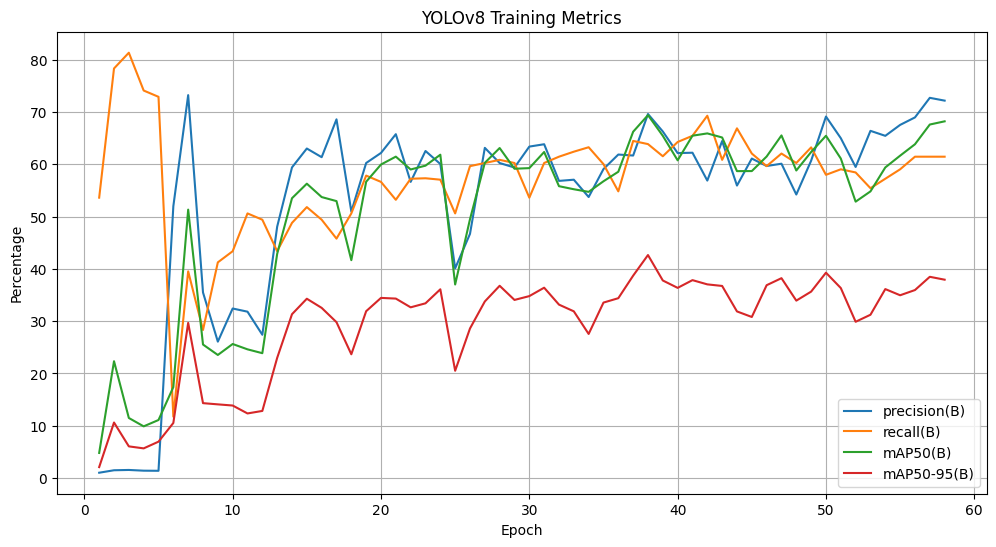

Final Metrics:
precision(B): 72.17%
recall(B): 61.45%
mAP50(B): 68.21%
mAP50-95(B): 37.93%


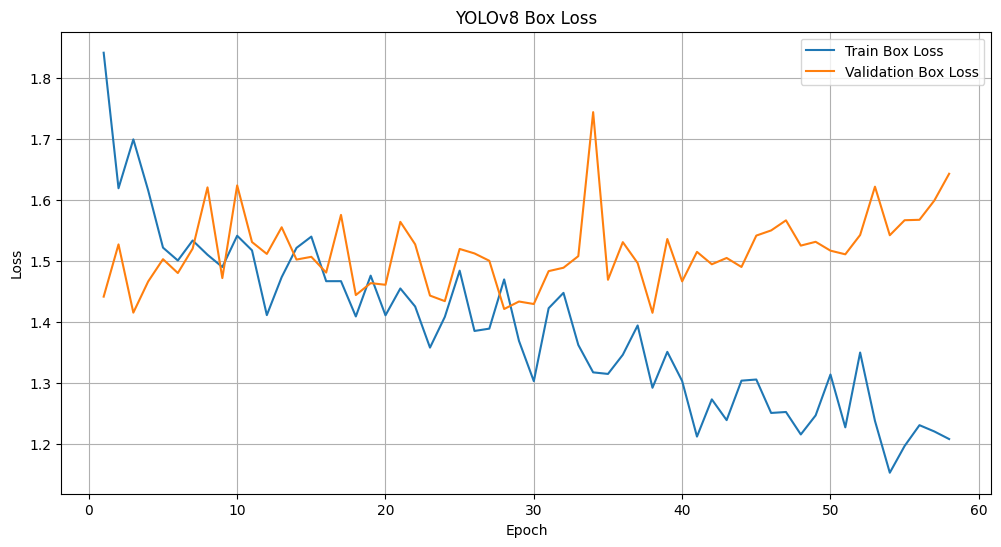

In [17]:
# prompt: can you provide the model accuracy and losses in percentage and show graph for it

import pandas as pd
import matplotlib.pyplot as plt

# Find the results.csv file
results_files = glob.glob('/content/runs/detect/crater_model/*.csv')
print(f"Found results files: {results_files}")

if results_files:
    results_df = pd.read_csv(results_files[0])

    # Extract relevant columns
    metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']  # Box metrics

    # Calculate percentages
    for col in metrics:
      results_df[col] = results_df[col] * 100

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot metrics
    for metric in metrics:
        plt.plot(results_df['epoch'], results_df[metric], label=metric.replace('metrics/', ''))

    plt.xlabel('Epoch')
    plt.ylabel('Percentage')  # Updated y-label
    plt.title('YOLOv8 Training Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the last row of metrics for easy access
    last_metrics = results_df.iloc[-1][metrics].to_dict()
    print(f"Final Metrics:")
    for metric_name, metric_value in last_metrics.items():
        print(f"{metric_name.replace('metrics/', '')}: {metric_value:.2f}%")  # Added percentage format

    # Plotting Losses
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('YOLOv8 Box Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("No results.csv files found, skipping plotting and metrics display.")
